**FPN Segmentation**

**Downloading required modules**

In [1]:
!pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.4 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 4.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=de95a4bda4498de4bc328279e19de56736fa43b92037e71a09a96da878f22a6e
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=e0b1f5c4ad489405c8b49f9ad20cf2b2e9c7204e446dc760bf0464e3bdab1a48
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [2]:
!pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.6/290.6 kB 8.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 16.7 MB/s eta 0:00:0000:01
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.19
    Uninstalling albucore-0.0.19:
      Successfully uninstalled albucore-0.0.19
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20


**Importing required modules**

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import segmentation_models_pytorch as smp
from sklearn.metrics import confusion_matrix
import cv2
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random

In [4]:
# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [5]:
# Define paths (adjust according to dataset location on Kaggle)
image_dir = '/kaggle/input/deepglobe-land-cover-classification-dataset/train'
mask_dir = '/kaggle/input/deepglobe-land-cover-classification-dataset/train'

**Dataset preprocessing**

In [6]:
# Collect image and mask paths
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
mask_files = [f.replace('_sat.jpg', '_mask.png') for f in image_files]

image_paths = [os.path.join(image_dir, f) for f in image_files]
mask_paths = [os.path.join(mask_dir, f) for f in mask_files]

# Verify that all masks exist
for mp in mask_paths:
    if not os.path.exists(mp):
        raise FileNotFoundError(f"Mask {mp} not found")

# Split into train and validation
indices = np.random.permutation(len(image_paths))
split = int(0.8 * len(indices))
train_indices = indices[:split]
val_indices = indices[split:]

In [7]:
train_image_paths = [image_paths[i] for i in train_indices]
train_mask_paths = [mask_paths[i] for i in train_indices]
val_image_paths = [image_paths[i] for i in val_indices]
val_mask_paths = [mask_paths[i] for i in val_indices]

**Applying Transforms**

In [8]:
# Define color to class mapping (adjust according to dataset documentation)
colors = np.array([
    [0, 255, 255],   # Urban land (0)
    [255, 255, 0],    # Agriculture (1)
    [255, 0, 255],    # Rangeland (2)
    [0, 255, 0],      # Forest (3)
    [0, 0, 255],      # Water (4)
    [255, 255, 255],  # Barren (5)
    [0, 0, 0]         # Unknown (6)
], dtype=np.uint8)

# Define transforms
transform_train = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

transform_val = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

**Dataset class**

In [9]:
class DeepGlobeDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.colors = colors

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # ... (image loading code remains the same)
        image = cv2.cvtColor(cv2.imread(self.image_paths[idx]), cv2.COLOR_BGR2RGB)
        mask_rgb = cv2.cvtColor(cv2.imread(self.mask_paths[idx]), cv2.COLOR_BGR2RGB)

        # Convert mask to class indices
        h, w = mask_rgb.shape[:2]
        mask_flat = mask_rgb.reshape(-1, 3)
        color_diff = np.abs(mask_flat[:, None, :] - self.colors[None, :, :])
        distance = np.sum(color_diff, axis=2)
        class_indices = np.argmin(distance, axis=1)
        class_mask = class_indices.reshape(h, w)

        if self.transform:
            transformed = self.transform(image=image, mask=class_mask)
            image = transformed['image']
            mask = transformed['mask'].long()  # Explicit cast to long
        else:
            image = A.ToTensorV2()(image=image)['image']
            mask = torch.from_numpy(class_mask).long()  # Already correct

        return image, mask

**Dataset and dataloaders**

In [10]:
# Create datasets and dataloaders
train_dataset = DeepGlobeDataset(train_image_paths, train_mask_paths, transform_train)
val_dataset = DeepGlobeDataset(val_image_paths, val_mask_paths, transform_val)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

**Loading FPN model using smp module**

In [15]:
# Model setup
model = smp.FPN(
    encoder_name='efficientnet-b3',
    encoder_weights='imagenet',
    in_channels=3,
    classes=7
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)


cuda


In [16]:
# Loss and optimizer
ce_loss = nn.CrossEntropyLoss()
dice_loss = smp.losses.DiceLoss(mode='multiclass', classes=7)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 20
best_val_miou = 0.0

**Training loop**

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_cm = np.zeros((7, 7), dtype=np.int64)

    for images, masks in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training'):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss_ce = ce_loss(outputs, masks)
        loss_dice = dice_loss(outputs, masks)
        loss = loss_ce + loss_dice

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Update confusion matrix
        preds = torch.argmax(outputs.detach(), dim=1)
        masks_np = masks.cpu().numpy().flatten()
        preds_np = preds.cpu().numpy().flatten()
        cm = confusion_matrix(masks_np, preds_np, labels=range(7))
        total_cm += cm

    # Calculate metrics
    iou_per_class = []
    for i in range(7):
        tp = total_cm[i, i]
        fp = total_cm[:, i].sum() - tp
        fn = total_cm[i, :].sum() - tp
        iou = tp / (tp + fp + fn + 1e-9)
        iou_per_class.append(iou)
    miou = np.mean(iou_per_class)
    pixel_acc = np.diag(total_cm).sum() / total_cm.sum()

    print(f'Train Loss: {running_loss / len(train_loader):.4f}, mIoU: {miou:.4f}, Pixel Acc: {pixel_acc:.4f}')

    # Validation
    model.eval()
    val_running_loss = 0.0
    val_total_cm = np.zeros((7, 7), dtype=np.int64)

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation'):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss_ce = ce_loss(outputs, masks)
            loss_dice = dice_loss(outputs, masks)
            loss = loss_ce + loss_dice
            val_running_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            masks_np = masks.cpu().numpy().flatten()
            preds_np = preds.cpu().numpy().flatten()
            cm = confusion_matrix(masks_np, preds_np, labels=range(7))
            val_total_cm += cm

    # Calculate validation metrics
    val_iou_per_class = []
    for i in range(7):
        tp = val_total_cm[i, i]
        fp = val_total_cm[:, i].sum() - tp
        fn = val_total_cm[i, :].sum() - tp
        iou = tp / (tp + fp + fn + 1e-9)
        val_iou_per_class.append(iou)
    val_miou = np.mean(val_iou_per_class)
    val_pixel_acc = np.diag(val_total_cm).sum() / val_total_cm.sum()

    print(f'Val Loss: {val_running_loss / len(val_loader):.4f}, Val mIoU: {val_miou:.4f}, Val Pixel Acc: {val_pixel_acc:.4f}')

    # Save best model
    if val_miou > best_val_miou:
        best_val_miou = val_miou
        torch.save(model.state_dict(), '/kaggle/working/best_model.pth')
        print(f'Best model saved with mIoU: {best_val_miou:.4f}')

print('Training Complete!')

Epoch 1/20 - Training: 100%|██████████| 81/81 [09:47<00:00,  7.25s/it]


Train Loss: 1.8576, mIoU: 0.2898, Pixel Acc: 0.6434


Epoch 1/20 - Validation: 100%|██████████| 21/21 [02:24<00:00,  6.87s/it]


Val Loss: 1.1793, Val mIoU: 0.4305, Val Pixel Acc: 0.7962
Best model saved with mIoU: 0.4305


Epoch 2/20 - Training: 100%|██████████| 81/81 [09:36<00:00,  7.11s/it]


Train Loss: 1.2950, mIoU: 0.4352, Pixel Acc: 0.7623


Epoch 2/20 - Validation: 100%|██████████| 21/21 [02:21<00:00,  6.74s/it]


Val Loss: 1.1060, Val mIoU: 0.4769, Val Pixel Acc: 0.8088
Best model saved with mIoU: 0.4769


Epoch 3/20 - Training: 100%|██████████| 81/81 [09:32<00:00,  7.07s/it]


Train Loss: 1.1825, mIoU: 0.4678, Pixel Acc: 0.7819


Epoch 3/20 - Validation: 100%|██████████| 21/21 [02:25<00:00,  6.91s/it]


Val Loss: 0.9768, Val mIoU: 0.5189, Val Pixel Acc: 0.8309
Best model saved with mIoU: 0.5189


Epoch 4/20 - Training: 100%|██████████| 81/81 [09:36<00:00,  7.12s/it]


Train Loss: 1.0833, mIoU: 0.5166, Pixel Acc: 0.8028


Epoch 4/20 - Validation: 100%|██████████| 21/21 [02:21<00:00,  6.76s/it]


Val Loss: 0.9575, Val mIoU: 0.5362, Val Pixel Acc: 0.8440
Best model saved with mIoU: 0.5362


Epoch 5/20 - Training: 100%|██████████| 81/81 [09:36<00:00,  7.11s/it]


Train Loss: 0.9933, mIoU: 0.5462, Pixel Acc: 0.8200


Epoch 5/20 - Validation: 100%|██████████| 21/21 [02:22<00:00,  6.78s/it]


Val Loss: 0.8712, Val mIoU: 0.5666, Val Pixel Acc: 0.8552
Best model saved with mIoU: 0.5666


Epoch 6/20 - Training: 100%|██████████| 81/81 [09:40<00:00,  7.17s/it]


Train Loss: 0.9394, mIoU: 0.5933, Pixel Acc: 0.8310


Epoch 6/20 - Validation: 100%|██████████| 21/21 [02:23<00:00,  6.85s/it]


Val Loss: 0.8329, Val mIoU: 0.5840, Val Pixel Acc: 0.8619
Best model saved with mIoU: 0.5840


Epoch 7/20 - Training: 100%|██████████| 81/81 [09:42<00:00,  7.19s/it]


Train Loss: 0.9101, mIoU: 0.6227, Pixel Acc: 0.8375


Epoch 7/20 - Validation: 100%|██████████| 21/21 [02:22<00:00,  6.80s/it]


Val Loss: 0.8143, Val mIoU: 0.6079, Val Pixel Acc: 0.8624
Best model saved with mIoU: 0.6079


Epoch 8/20 - Training: 100%|██████████| 81/81 [09:47<00:00,  7.25s/it]


Train Loss: 0.8456, mIoU: 0.6507, Pixel Acc: 0.8499


Epoch 8/20 - Validation: 100%|██████████| 21/21 [02:23<00:00,  6.84s/it]


Val Loss: 0.8157, Val mIoU: 0.6203, Val Pixel Acc: 0.8661
Best model saved with mIoU: 0.6203


Epoch 9/20 - Training: 100%|██████████| 81/81 [09:35<00:00,  7.11s/it]


Train Loss: 0.8100, mIoU: 0.6579, Pixel Acc: 0.8588


Epoch 9/20 - Validation: 100%|██████████| 21/21 [02:22<00:00,  6.77s/it]


Val Loss: 0.7967, Val mIoU: 0.6231, Val Pixel Acc: 0.8710
Best model saved with mIoU: 0.6231


Epoch 10/20 - Training: 100%|██████████| 81/81 [09:35<00:00,  7.11s/it]


Train Loss: 0.7915, mIoU: 0.6728, Pixel Acc: 0.8625


Epoch 10/20 - Validation: 100%|██████████| 21/21 [02:22<00:00,  6.78s/it]


Val Loss: 0.8231, Val mIoU: 0.6266, Val Pixel Acc: 0.8639
Best model saved with mIoU: 0.6266


Epoch 11/20 - Training: 100%|██████████| 81/81 [09:36<00:00,  7.12s/it]


Train Loss: 0.7345, mIoU: 0.6962, Pixel Acc: 0.8753


Epoch 11/20 - Validation: 100%|██████████| 21/21 [02:22<00:00,  6.79s/it]


Val Loss: 0.8385, Val mIoU: 0.6143, Val Pixel Acc: 0.8660


Epoch 12/20 - Training: 100%|██████████| 81/81 [09:34<00:00,  7.10s/it]


Train Loss: 0.7598, mIoU: 0.6941, Pixel Acc: 0.8712


Epoch 12/20 - Validation: 100%|██████████| 21/21 [02:22<00:00,  6.80s/it]


Val Loss: 0.8212, Val mIoU: 0.6361, Val Pixel Acc: 0.8690
Best model saved with mIoU: 0.6361


Epoch 13/20 - Training: 100%|██████████| 81/81 [09:35<00:00,  7.11s/it]


Train Loss: 0.7281, mIoU: 0.6893, Pixel Acc: 0.8763


Epoch 13/20 - Validation: 100%|██████████| 21/21 [02:22<00:00,  6.77s/it]


Val Loss: 0.7942, Val mIoU: 0.6259, Val Pixel Acc: 0.8731


Epoch 14/20 - Training: 100%|██████████| 81/81 [09:37<00:00,  7.13s/it]


Train Loss: 0.6765, mIoU: 0.7165, Pixel Acc: 0.8880


Epoch 14/20 - Validation: 100%|██████████| 21/21 [02:23<00:00,  6.83s/it]


Val Loss: 0.8018, Val mIoU: 0.6328, Val Pixel Acc: 0.8733


Epoch 15/20 - Training: 100%|██████████| 81/81 [09:36<00:00,  7.12s/it]


Train Loss: 0.6658, mIoU: 0.7261, Pixel Acc: 0.8889


Epoch 15/20 - Validation: 100%|██████████| 21/21 [02:22<00:00,  6.79s/it]


Val Loss: 0.8207, Val mIoU: 0.6412, Val Pixel Acc: 0.8695
Best model saved with mIoU: 0.6412


Epoch 16/20 - Training: 100%|██████████| 81/81 [09:36<00:00,  7.11s/it]


Train Loss: 0.6501, mIoU: 0.7298, Pixel Acc: 0.8920


Epoch 16/20 - Validation: 100%|██████████| 21/21 [02:21<00:00,  6.76s/it]


Val Loss: 0.8143, Val mIoU: 0.6385, Val Pixel Acc: 0.8728


Epoch 17/20 - Training: 100%|██████████| 81/81 [09:45<00:00,  7.23s/it]


Train Loss: 0.6421, mIoU: 0.7277, Pixel Acc: 0.8943


Epoch 17/20 - Validation: 100%|██████████| 21/21 [02:22<00:00,  6.77s/it]


Val Loss: 0.8409, Val mIoU: 0.6218, Val Pixel Acc: 0.8708


Epoch 18/20 - Training: 100%|██████████| 81/81 [09:40<00:00,  7.17s/it]


Train Loss: 0.6302, mIoU: 0.7411, Pixel Acc: 0.8974


Epoch 18/20 - Validation:   0%|          | 0/21 [00:00<?, ?it/s]

**Helper function**

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, dataset, device, colors, num_samples=3):
    """
    Visualize original image, ground truth mask, and predicted mask
    Args:
        model: Trained model
        dataset: Dataset object (e.g., val_dataset)
        device: cuda/cpu
        colors: Color mapping array
        num_samples: Number of samples to visualize
    """
    model.eval()
    indices = np.random.choice(len(dataset), num_samples)

    plt.figure(figsize=(18, 4*num_samples))

    for i, idx in enumerate(indices):
        # Get data
        image, true_mask = dataset[idx]
        image_tensor = image.unsqueeze(0).to(device)

        # Prediction
        with torch.no_grad():
            output = model(image_tensor)
        pred_mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()

        # Convert image to display format
        image = image.cpu().numpy().transpose(1, 2, 0)
        image = (image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]) * 255
        image = image.astype(np.uint8)

        # Convert masks to RGB
        def mask_to_rgb(mask_array):
            h, w = mask_array.shape
            rgb = np.zeros((h, w, 3), dtype=np.uint8)
            for class_idx, color in enumerate(colors):
                rgb[mask_array == class_idx] = color
            return rgb

        true_mask_rgb = mask_to_rgb(true_mask.numpy())
        pred_mask_rgb = mask_to_rgb(pred_mask)

        # Plot
        plt.subplot(num_samples, 3, i*3+1)
        plt.imshow(image)
        plt.title(f"Sample {i+1}\nOriginal Image")
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3+2)
        plt.imshow(true_mask_rgb)
        plt.title("Ground Truth Mask")
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3+3)
        plt.imshow(pred_mask_rgb)
        plt.title("Predicted Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [19]:
# Define colors (must match your dataset's class order)
colors = np.array([
    [0, 255, 255],   # Urban land
    [255, 255, 0],   # Agriculture
    [255, 0, 255],   # Rangeland
    [0, 255, 0],     # Forest
    [0, 0, 255],     # Water
    [255, 255, 255], # Barren
    [0, 0, 0]        # Unknown
])

**Model mask prediction**

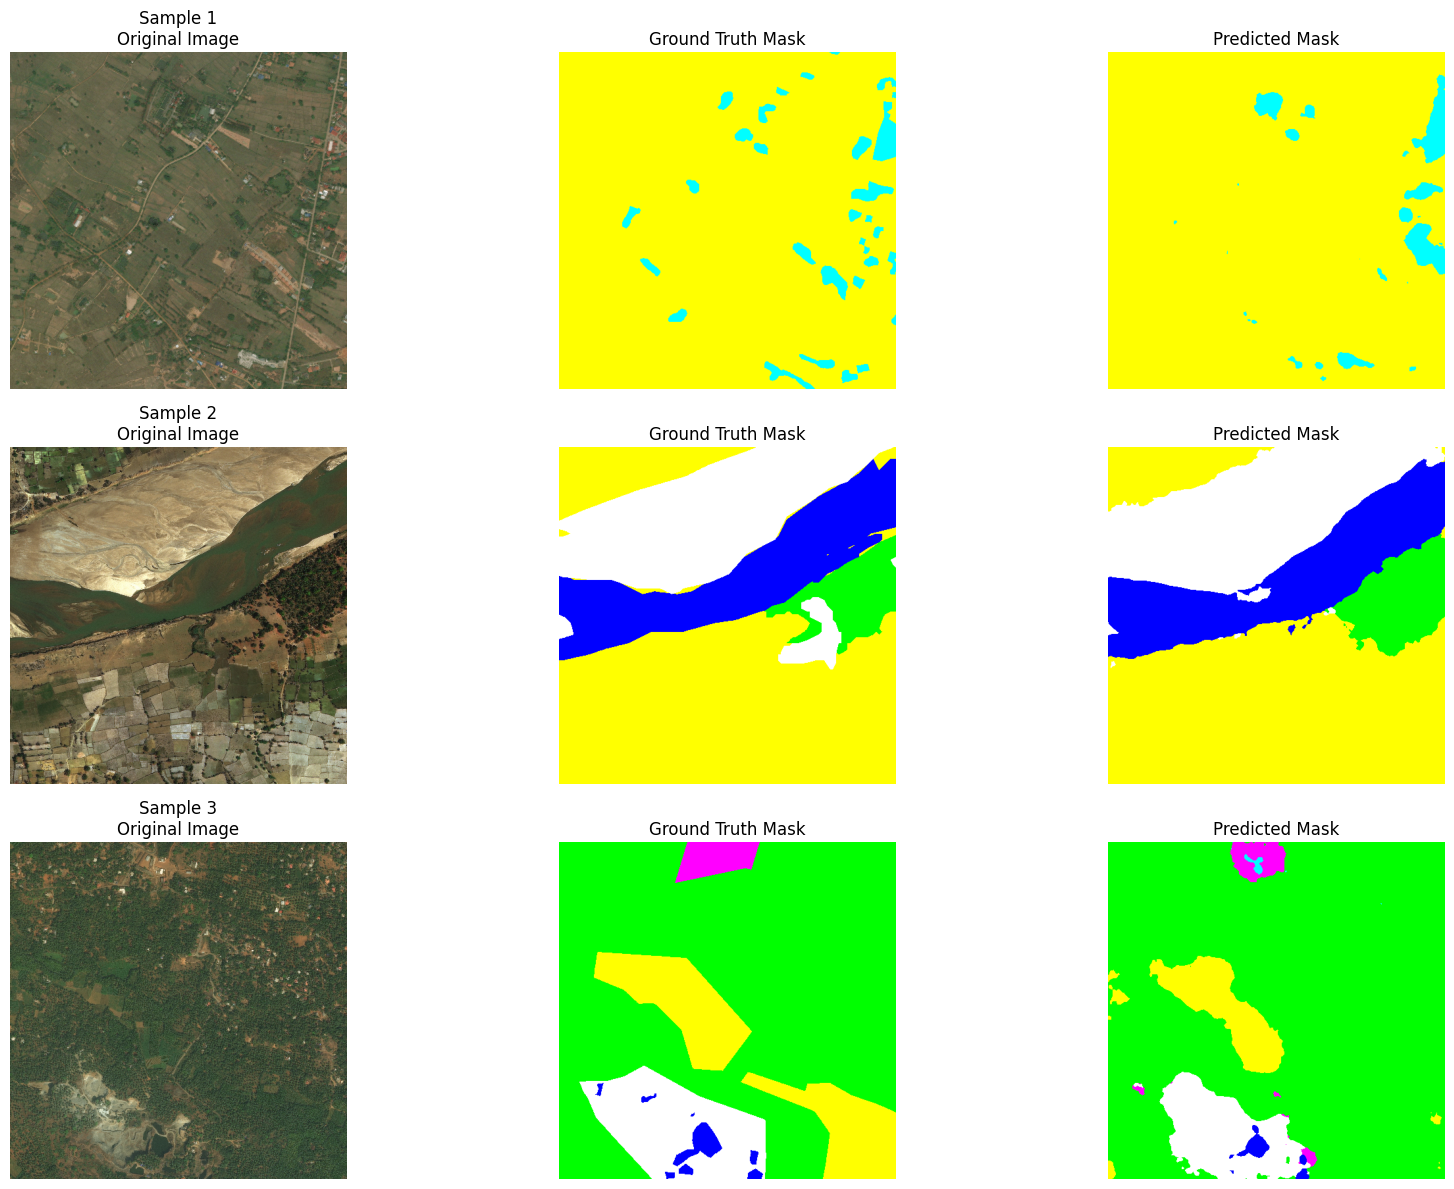

In [20]:
# Usage after training
visualize_predictions(
    model=model,
    dataset=val_dataset,  # Use your validation dataset
    device=device,
    colors=colors,
    num_samples=3  # Number of examples to show
)

**Evaluating model on different metrics**

In [17]:
def evaluate_model(model_path, val_loader, device):
    # Load best model
    model = smp.FPN(
    encoder_name='efficientnet-b3',
    encoder_weights='imagenet',
    in_channels=3,
    classes=7
)
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model.eval()
    
    # Initialize metrics
    dice_loss = smp.losses.DiceLoss(mode='multiclass', classes=7)
    total_dice = 0.0
    total_cm = np.zeros((7, 7), dtype=np.int64)
    
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc="Evaluating"):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            
            # Calculate Dice Loss
            loss_dice = dice_loss(outputs, masks)
            total_dice += loss_dice.item()
            
            # For other metrics
            preds = torch.argmax(outputs, dim=1)
            masks_np = masks.cpu().numpy().flatten()
            preds_np = preds.cpu().numpy().flatten()
            cm = confusion_matrix(masks_np, preds_np, labels=range(7))
            total_cm += cm
    
    # Calculate metrics
    val_dice = total_dice / len(val_loader)
    
    val_iou_per_class = []
    for i in range(7):
        tp = total_cm[i, i]
        fp = total_cm[:, i].sum() - tp
        fn = total_cm[i, :].sum() - tp
        iou = tp / (tp + fp + fn + 1e-9)
        val_iou_per_class.append(iou)
    val_miou = np.mean(val_iou_per_class)
    val_pixel_acc = np.diag(total_cm).sum() / total_cm.sum()
    
    print(f"\nFinal Evaluation Results:")
    print(f"Dice Loss: {val_dice:.4f}")
    print(f"mIoU: {val_miou:.4f}")
    print(f"Pixel Accuracy: {val_pixel_acc:.4f}")

# Usage
evaluate_model(
    model_path='/kaggle/input/fpn_trained/pytorch/default/1/fpn.pth',
    val_loader=val_loader,
    device=device
)

<ipython-input-17-007969cefd47>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
Evaluating: 100%|██████████| 21/21 [02:33<00:0


Final Evaluation Results:
Dice Loss: 0.3496
mIoU: 0.6472
Pixel Accuracy: 0.8731
